<a href="https://colab.research.google.com/github/Safa30/CSE475_Machine_Learning/blob/main/Lab/lab_2/Lab2_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imported required libraries for this task

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

# Loaded the Dataset

In [22]:
!gdown --id 1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf
To: /content/Mall_Customers.csv
100% 3.98k/3.98k [00:00<00:00, 11.7MB/s]


# Data Overview and Initial Inspection

In [13]:
df =  pd.read_csv("/content/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [23]:
# Display basic information about the DataFrame
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None

In [24]:
# Check for missing values
display(df.isnull().sum())

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [25]:
# Display descriptive statistics for numerical columns
display(df.describe())

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


### Summary:

The dataset consists of 200 entries and 5 columns: `CustomerID`, `Gender`, `Age`, `Annual Income (k$)`, and `Spending Score (1-100)`. There are no missing values in any of the columns. The data types are suitable for analysis, with `Age`, `Annual Income (k$)`, and `Spending Score (1-100)` being numerical (`int64`), and `Gender` being an object (`str`). The `CustomerID` column is an identifier and may not be relevant for clustering analysis.

#Performed an Exploratory Data Analysis (EDA) on the dataset, including visualizing the distribution of numerical features

### Distribution of Numerical Features

 Visualized the distribution of 'Age', 'Annual Income (k$)', and 'Spending Score (1-100)' using histograms and KDE plots to understand their patterns and ranges.


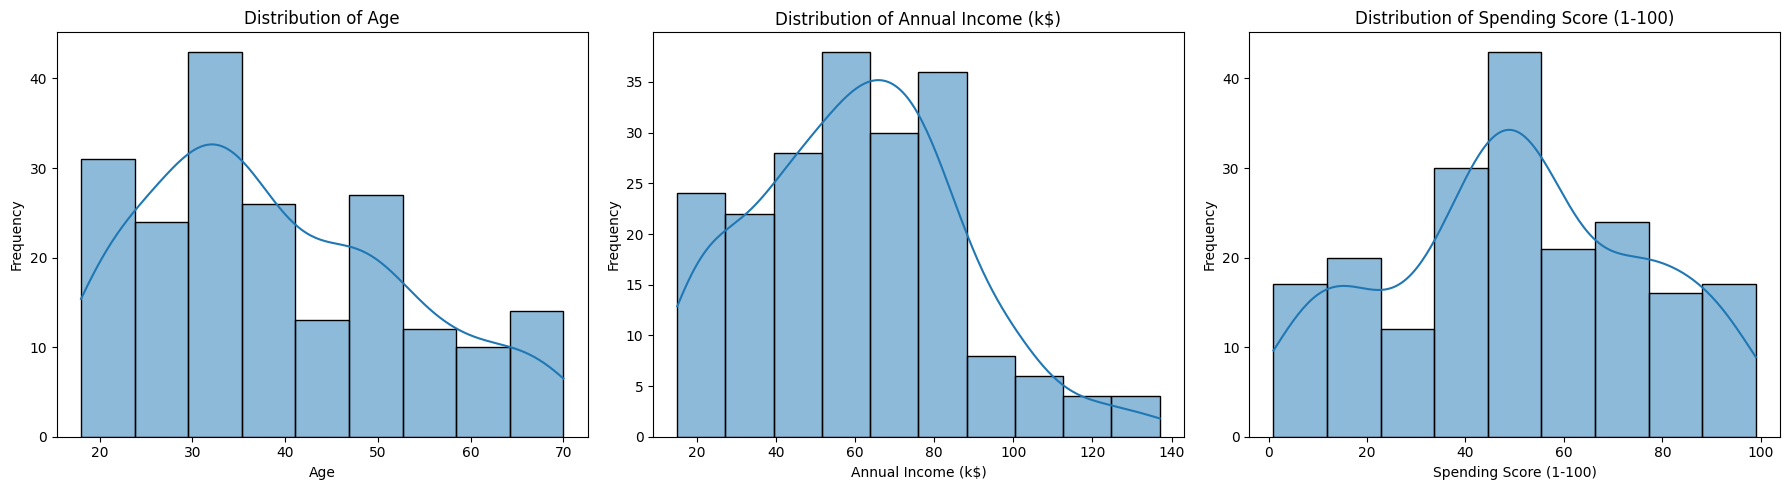

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['Age'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of Age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')

sns.histplot(df['Annual Income (k$)'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Annual Income (k$)')
ax[1].set_xlabel('Annual Income (k$)')
ax[1].set_ylabel('Frequency')

sns.histplot(df['Spending Score (1-100)'], kde=True, ax=ax[2])
ax[2].set_title('Distribution of Spending Score (1-100)')
ax[2].set_xlabel('Spending Score (1-100)')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##Gender Distribution


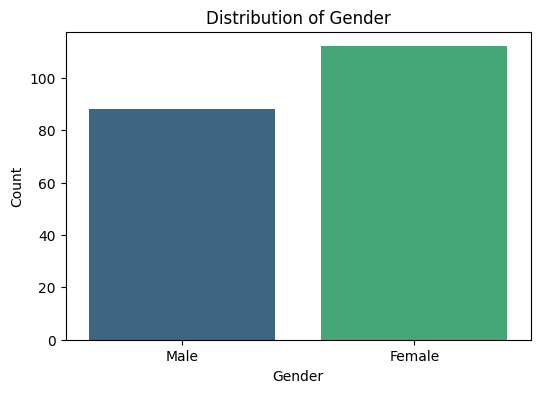

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', hue='Gender', palette='viridis', legend=False)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

## Relationships Between Key Features

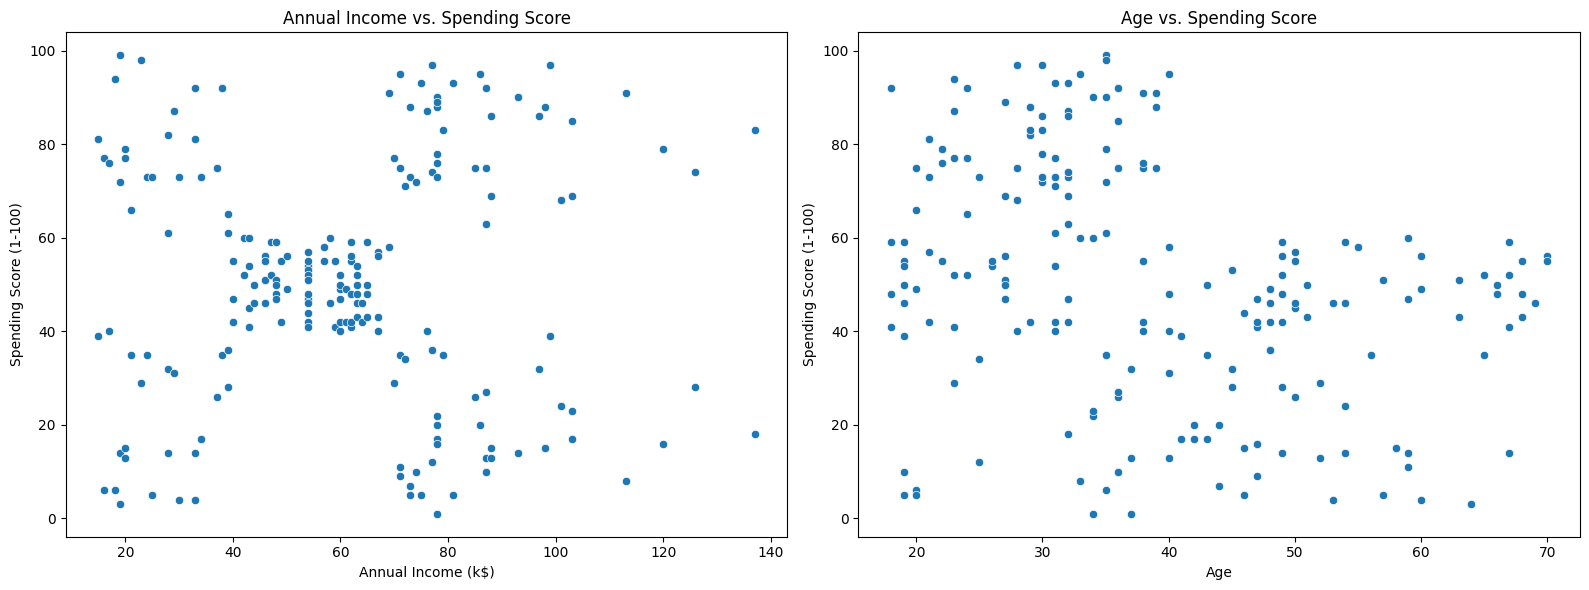

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', ax=ax[0])
ax[0].set_title('Annual Income vs. Spending Score')
ax[0].set_xlabel('Annual Income (k$)')
ax[0].set_ylabel('Spending Score (1-100)')

sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', ax=ax[1])
ax[1].set_title('Age vs. Spending Score')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

## Correlation Heatmap

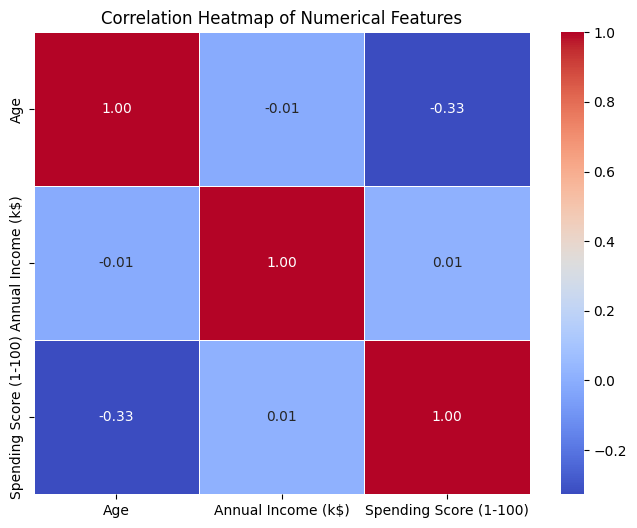

In [29]:
numerical_df = df.select_dtypes(include=np.number).drop(columns=['CustomerID'])
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Summary:

#### Data Analysis Key Findings:

*   **Age Distribution**: The majority of customers are young to middle-aged adults, with a peak between 30-35 years.

*   **Annual Income Distribution**: Most customers have annual incomes ranging from \$40,000 to \$80,000, indicating a somewhat normal distribution.

*   **Spending Score Distribution**: The spending score exhibits peaks around 40-60 and 80-90, suggesting potential distinct customer segments rather than a uniform distribution.

*   **Gender Distribution**: The dataset contains more female customers (approximately 112) than male customers (approximately 88), indicating a slight gender imbalance.
*   **Annual Income vs. Spending Score**: The scatter plot reveals distinct customer clusters (e.g., low income/low spending, high income/high spending), strongly suggesting the presence of different customer segments.

*   **Age vs. Spending Score**: Younger customers (20-40 years) show a wider range of spending scores, including high scores, while older customers (>50 years) generally exhibit lower spending scores.

*   **Correlation Analysis**:
    *   There is a moderate negative correlation (-0.33) between 'Age' and 'Spending Score (1-100)', suggesting that younger customers tend to have higher spending scores.
    *   'Annual Income (k\$)' and 'Spending Score (1-100)' show a very weak positive correlation (0.01), indicating that a simple linear relationship across the entire dataset does not fully capture the complex patterns observed in the scatter plot.

#### Insights:

*   The presence of distinct clusters in the 'Annual Income' versus 'Spending Score' plot indicates that customer segmentation techniques, such as K-Means clustering, would be highly beneficial for understanding different customer behaviors and tailoring marketing strategies.
*   The negative correlation between 'Age' and 'Spending Score' suggests that marketing efforts for higher spending items might be more effective when targeted towards younger demographics, while loyalty programs could be designed to encourage spending among older customers.
